In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc

# train, predict_score, feature_importance functions

In [2]:
def train_tune_classifier(clf, param_grid, X_train, y_train, scoring):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
    
    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring=scoring, verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best params:")
    print(grid_search.best_params_)
    print(f"Internal CV score: {grid_search.best_score_:.3f}")
    return grid_search

In [3]:
def print_prediction_score(grid_search, X_test, y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    y_pred_prob = grid_search.predict_proba(X_test)[:, 1]  # Probability of class 1
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"Sensitivity (Recall for class 1):, {sensitivity:.3f}")
    print(f"Specificity (Recall for class 0):, {specificity:.3f}")
    print(f"Precision:, {precision:.3f}")
    print(f"F1-Score:, {f1:.3f}")
    print(f"AUC-ROC Score:, {roc_auc:.3f}")

In [4]:
def print_feature_importance(grid_search, above_zero=True):
    best_classifier = grid_search.best_estimator_.named_steps['classifier']
    
    feature_importances = best_classifier.feature_importances_ * 100
    
    preprocessor = grid_search.best_estimator_.named_steps['preprocessor']
    onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names = list(onehot_encoder.get_feature_names_out(input_features=cat_cols))
    all_feature_names = categorical_feature_names + num_cols
    
    feature_importance_pairs = list(zip(all_feature_names, feature_importances))
    sorted_feature_importances = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

    return sorted_feature_importances

In [5]:
def plot_feature_importances(sorted_feature_importances, title="Feature Importances", color="blue"):
    features, importances = zip(*sorted_feature_importances)
    importances = np.asarray(importances)
    importances = tuple(importances/sum(importances))

    plt.figure(figsize=(10, len(features) * 0.4))  # Adjust the figure size
    plt.barh(features, importances, color=color)  # Setting the color of the bars here
    plt.title(title)
    plt.xlim(0, 1)
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.show()

In [6]:
# Load your dataset
data = pd.read_csv('stat_final_csv.csv')

In [7]:
data['Age.61'] = 0
data.loc[data['Age ']>=61,'Age.61'] = 1
data['Age.51'] = 0
data.loc[data['Age ']>=51,'Age.51'] = 1
data['Age.71'] = 0
data.loc[data['Age ']>=71,'Age.71'] = 1
data['CA 125(2group)'] = 0
data.loc[data['CA 125']>35,'CA 125(2group)'] = 1
data['Histology(3group)'] = data['Histology_specific']
data.loc[data['Histology_specific']>2,'Histology(3group)'] = 3
data['Histology(2group)'] = data['Histology(3group)']
data.loc[data['Histology(2group)']<3,'Histology(2group)'] = 0
data.loc[data['Histology(2group)']==3,'Histology(2group)'] = 1

In [8]:
data2 = data[data['recurrence']!='na'][[
          'Age.51',
          'Histology(2group)',
          'MI(2group)',
          'LVI(2group)',
          'CA 125',
          'Mass size binary(2cm)',
          'ultrastaging_lymphnode_metastasis']]
print(data2.shape)
print(data2.keys())

(109, 7)
Index(['Age.51', 'Histology(2group)', 'MI(2group)', 'LVI(2group)', 'CA 125',
       'Mass size binary(2cm)', 'ultrastaging_lymphnode_metastasis'],
      dtype='object')


# Preprocess data

In [9]:
r = 22
data_train, data_test = train_test_split(
    data2, 
    test_size=0.3, 
    stratify=data2[['Histology(2group)',
                    #'Histology(3group)',
                    #'Age.51',
                    #'Age.61',
                    'ultrastaging_lymphnode_metastasis',
                    #'MI(2group)',
                    #'LVI(2group)',
                    'Mass size binary(2cm)'
                   ]], 
    random_state=r
)
print(data_train.shape,data_test.shape)

(76, 7) (33, 7)


In [10]:
print(sum(data_train['ultrastaging_lymphnode_metastasis']))
print(sum(data_test['ultrastaging_lymphnode_metastasis']))
print(data_train.groupby(['ultrastaging_lymphnode_metastasis']).size()/data_train.shape[0])
print(data_test.groupby(['ultrastaging_lymphnode_metastasis']).size()/data_test.shape[0])
print(data_train.groupby(['Histology(2group)']).size()/data_train.shape[0])
print(data_test.groupby(['Histology(2group)']).size()/data_test.shape[0])
print(data_train.groupby(['MI(2group)']).size()/data_train.shape[0])
print(data_test.groupby(['MI(2group)']).size()/data_test.shape[0])
print(data_train.groupby(['LVI(2group)']).size()/data_train.shape[0])
print(data_test.groupby(['LVI(2group)']).size()/data_test.shape[0])
print(data_train.groupby(['Age.51']).size()/data_train.shape[0])
print(data_test.groupby(['Age.51']).size()/data_test.shape[0])
print(data_train.groupby(['Mass size binary(2cm)']).size()/data_train.shape[0])
print(data_test.groupby(['Mass size binary(2cm)']).size()/data_test.shape[0])

9
4
ultrastaging_lymphnode_metastasis
0    0.881579
1    0.118421
dtype: float64
ultrastaging_lymphnode_metastasis
0    0.878788
1    0.121212
dtype: float64
Histology(2group)
0    0.802632
1    0.197368
dtype: float64
Histology(2group)
0    0.787879
1    0.212121
dtype: float64
MI(2group)
0    0.894737
1    0.105263
dtype: float64
MI(2group)
0    0.878788
1    0.121212
dtype: float64
LVI(2group)
0    0.802632
1    0.197368
dtype: float64
LVI(2group)
0    0.757576
1    0.242424
dtype: float64
Age.51
0    0.447368
1    0.552632
dtype: float64
Age.51
0    0.393939
1    0.606061
dtype: float64
Mass size binary(2cm)
0    0.434211
1    0.565789
dtype: float64
Mass size binary(2cm)
0    0.424242
1    0.575758
dtype: float64


In [11]:
# Split categorical and numerical columns
cat_cols = ['Histology(2group)',
            'MI(2group)',
            'Mass size binary(2cm)',
            'LVI(2group)',
            'Age.51'
            ]
num_cols = ['CA 125']

In [12]:
from scipy.stats import fisher_exact, chi2_contingency, mannwhitneyu

p_value_list = []
for cat in cat_cols+['ultrastaging_lymphnode_metastasis']:
    contingency_table_train = pd.crosstab(data_train[cat], columns='count')
    contingency_table_test = pd.crosstab(data_test[cat], columns='count')
    if pd.crosstab(data_train[cat], columns='count').shape[0] == 2 :
        _, p_value = fisher_exact([contingency_table_train['count'], contingency_table_test['count']])
    else :
        _, p_value, _, _ = chi2_contingency([contingency_table_train['count'], contingency_table_test['count']])
    print(cat, p_value)
    p_value_list.append(p_value)

Histology(2group) 1.0
MI(2group) 0.7519483948584343
Mass size binary(2cm) 1.0
LVI(2group) 0.6156613995686921
Age.51 0.6765186488101034
ultrastaging_lymphnode_metastasis 1.0


In [13]:
# Won't use continuous cols
X_train, X_test = data_train[cat_cols], data_test[cat_cols]
y_train, y_test = data_train['ultrastaging_lymphnode_metastasis'], data_test['ultrastaging_lymphnode_metastasis']
print(X_train.shape,X_test.shape)

(76, 5) (33, 5)


In [14]:
# Define preprocessing steps
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))
])

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        #('num', 'passthrough', num_cols)  # Assuming num_cols are numeric columns
    ])

In [15]:
dt = DecisionTreeClassifier(random_state=r)
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', dt)])

xgb = XGBClassifier(random_state=r)
xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', xgb)])

cat = CatBoostClassifier(random_state=r, silent=True)
cat_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', cat)])

rf = RandomForestClassifier(random_state=r)
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', rf)])

In [16]:
weight = (len(y_train)-sum(y_train))/sum(y_train)
print(weight, round(weight))

7.444444444444445 7


In [17]:
depth = 3
weight = 7

dt_params = {
    'classifier__max_depth': [depth],
    'classifier__class_weight': [{0:1, 1: weight}]
}

xgb_params = {
    'classifier__max_depth': [depth],
    'classifier__learning_rate': [0.01],
    'classifier__scale_pos_weight': [weight],
#     'classifier__alpha': [0.1],
#     'classifier__lambda': [0.1],
#     'classifier__eta' : [0.1],
#    'classifier__tree_method' : ['exact']
}

cat_params = {
    'classifier__depth': [depth],
    'classifier__iterations': [100],
    'classifier__learning_rate': [0.01],
    'classifier__scale_pos_weight': [weight],
}

rf_params = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [depth],
    #'classifier__min_samples_leaf': [3,5],
    #'classifier__max_features': ['sqrt','auto'],
    'classifier__class_weight': [{0:1, 1: weight}]
}
#{0:1, 1: weight},

In [18]:
%%capture
scoring = 'f1'

dt_grid_search = train_tune_classifier(dt_pipe, 
                                        dt_params, 
                                        X_train, y_train,
                                        scoring)
rf_grid_search = train_tune_classifier(rf_pipe,
                                       rf_params,
                                       X_train, y_train,
                                       scoring)
cat_grid_search = train_tune_classifier(cat_pipe, 
                                        cat_params, 
                                        X_train, y_train,
                                        scoring)
xgb_grid_search = train_tune_classifier(xgb_pipe, 
                                        xgb_params, 
                                        X_train, y_train,
                                        scoring)

In [19]:
y_pred = xgb_grid_search.predict(X_train)
print('XGBoostClassifier with trainset :')
print_prediction_score(xgb_grid_search, X_train, y_train, y_pred)

print('\n')
y_pred = cat_grid_search.predict(X_train)
print('CatBoostClassifier with trainset :')
print_prediction_score(cat_grid_search, X_train, y_train, y_pred)

# print('\n')
# y_pred = lgbm_grid_search.predict(X_train)
# print('LightGBMClassifier with trainset :')
# print_prediction_score(lgbm_grid_search, X_train, y_train, y_pred)

print('\n')
y_pred = dt_grid_search.predict(X_train)
print('DecisionTreeClassifier with trainset :')
print_prediction_score(dt_grid_search, X_train, y_train, y_pred)

print('\n')
y_pred = rf_grid_search.predict(X_train)
print('RandomForestClassifier with trainset :')
print_prediction_score(rf_grid_search, X_train, y_train, y_pred)

XGBoostClassifier with trainset :
Confusion Matrix:
[[50 17]
 [ 5  4]]
Sensitivity (Recall for class 1):, 0.444
Specificity (Recall for class 0):, 0.746
Precision:, 0.190
F1-Score:, 0.267
AUC-ROC Score:, 0.667


CatBoostClassifier with trainset :
Confusion Matrix:
[[45 22]
 [ 3  6]]
Sensitivity (Recall for class 1):, 0.667
Specificity (Recall for class 0):, 0.672
Precision:, 0.214
F1-Score:, 0.324
AUC-ROC Score:, 0.754


DecisionTreeClassifier with trainset :
Confusion Matrix:
[[35 32]
 [ 2  7]]
Sensitivity (Recall for class 1):, 0.778
Specificity (Recall for class 0):, 0.522
Precision:, 0.179
F1-Score:, 0.292
AUC-ROC Score:, 0.701


RandomForestClassifier with trainset :
Confusion Matrix:
[[65  2]
 [ 8  1]]
Sensitivity (Recall for class 1):, 0.111
Specificity (Recall for class 0):, 0.970
Precision:, 0.333
F1-Score:, 0.167
AUC-ROC Score:, 0.823


In [20]:
y_pred = xgb_grid_search.predict(X_test)
print('XGBoostClassifier with testset :')
print_prediction_score(xgb_grid_search, X_test, y_test, y_pred)

print('\n')
y_pred = cat_grid_search.predict(X_test)
print('CatBoostClassifier with testset :')
print_prediction_score(cat_grid_search, X_test, y_test, y_pred)

# print('\n')
# y_pred = lgbm_grid_search.predict(X_test)
# print('LightGBMClassifier with testset :')
# print_prediction_score(lgbm_grid_search, X_test, y_test, y_pred)

print('\n')
y_pred = dt_grid_search.predict(X_test)
print('DecisionTreeClassifier with testset :')
print_prediction_score(dt_grid_search, X_test, y_test, y_pred)

print('\n')
y_pred = rf_grid_search.predict(X_test)
print('RandomForestClassifier with testset :')
print_prediction_score(rf_grid_search, X_test, y_test, y_pred)

XGBoostClassifier with testset :
Confusion Matrix:
[[23  6]
 [ 1  3]]
Sensitivity (Recall for class 1):, 0.750
Specificity (Recall for class 0):, 0.793
Precision:, 0.333
F1-Score:, 0.462
AUC-ROC Score:, 0.767


CatBoostClassifier with testset :
Confusion Matrix:
[[19 10]
 [ 3  1]]
Sensitivity (Recall for class 1):, 0.250
Specificity (Recall for class 0):, 0.655
Precision:, 0.091
F1-Score:, 0.133
AUC-ROC Score:, 0.504


DecisionTreeClassifier with testset :
Confusion Matrix:
[[13 16]
 [ 3  1]]
Sensitivity (Recall for class 1):, 0.250
Specificity (Recall for class 0):, 0.448
Precision:, 0.059
F1-Score:, 0.095
AUC-ROC Score:, 0.315


RandomForestClassifier with testset :
Confusion Matrix:
[[27  2]
 [ 3  1]]
Sensitivity (Recall for class 1):, 0.250
Specificity (Recall for class 0):, 0.931
Precision:, 0.333
F1-Score:, 0.286
AUC-ROC Score:, 0.409


XGBoostClassifier feature_importance :


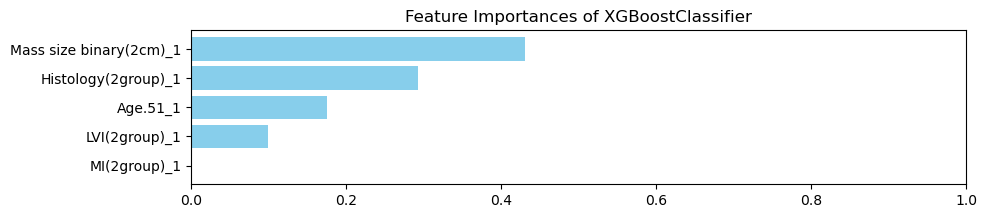



CatBoostClassifier feature_importance :


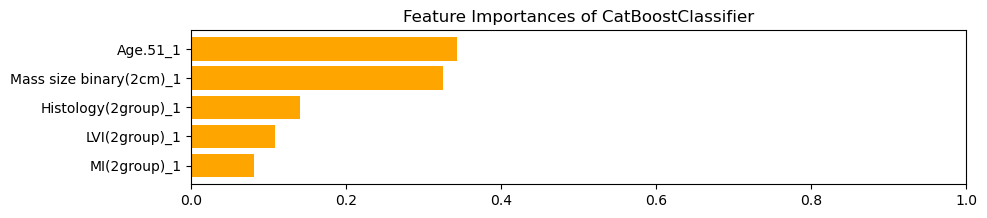



DecisionTreeClassifier feature_importance :


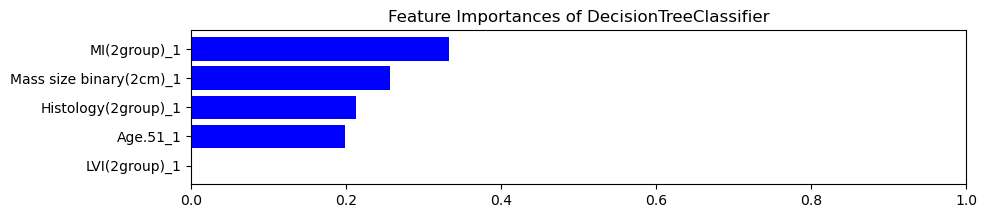



RandomForestClassifier feature_importance :


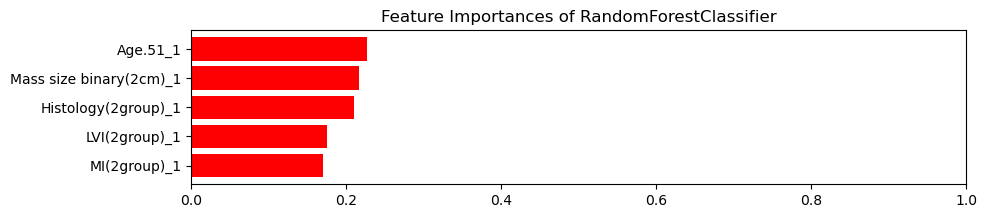

In [21]:
print('XGBoostClassifier feature_importance :')
xgb_sorted_feature_importances = print_feature_importance(xgb_grid_search,above_zero=False)
plot_feature_importances(xgb_sorted_feature_importances, 
                         'Feature Importances of XGBoostClassifier', 
                         color="skyblue")

print('\n')
print('CatBoostClassifier feature_importance :')
cat_sorted_feature_importances = print_feature_importance(cat_grid_search,above_zero=False)
plot_feature_importances(cat_sorted_feature_importances, 
                         'Feature Importances of CatBoostClassifier', 
                         color="orange")

print('\n')
print('DecisionTreeClassifier feature_importance :')
dt_sorted_feature_importances = print_feature_importance(dt_grid_search,above_zero=False)
plot_feature_importances(dt_sorted_feature_importances, 
                         'Feature Importances of DecisionTreeClassifier', 
                         color="blue")

# print('\n')
# print('LightGBMClassifier feature_importance :')
# lgbm_sorted_feature_importances = print_feature_importance(lgbm_grid_search,above_zero=False)
# plot_feature_importances(lgbm_sorted_feature_importances, 
#                          'Feature Importances of LightGBMClassifier', 
#                          color="blue")

print('\n')
print('RandomForestClassifier feature_importance :')
rf_sorted_feature_importances = print_feature_importance(rf_grid_search,above_zero=False)
plot_feature_importances(rf_sorted_feature_importances, 
                         'Feature Importances of RandomForestClassifier', 
                         color="red")
